In [ ]:
!pip install transformers
!pip install tweet-preprocessor
import torch
from transformers import BertTokenizer, BertModel
from google.colab import files
import io
import pandas as pd
import preprocessor as p
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 50.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 65.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 6.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
uploaded = files.upload()

Saving all-threads.csv to all-threads.csv


In [ ]:
import pandas as pd

#For the time being we will be testing on one thread until we feel like there are enough features and until we can actually load them into our model
pheme = pd.read_csv("all-threads.csv")
#pheme.drop(columns=pheme.columns[0], axis=1, inplace=True)
print(pheme.shape)
pheme.head(4)

(6416, 8)


,Unnamed: 0,rid,created_at,cleaned_text,followers,retweets,favourited,label
0,0,552783667052167168,07 Jan 2015 11:07:51,france people dead shooting hq satirical weekl...,129573,486,38,1
1,1,552783745565347840,07 Jan 2015 11:08:09,ten killed shooting headquarters french satiri...,529882,127,15,1
2,2,552784168849907712,07 Jan 2015 11:09:50,breaking dead shooting headquarters french sat...,499741,105,15,1
3,3,552784526955806720,07 Jan 2015 11:11:16,reuters people shot dead headquarters french s...,1377384,412,32,1


In [ ]:
pheme = pheme[pheme["label"] != 'None'].reset_index(drop=True)
print(pheme.shape)

(6415, 8)


In [ ]:
pheme_train,  pheme_test = np.split(pheme.sample(frac=1, random_state=42), 
                                     [int(.8*len(pheme))])

print(len(pheme_train), len(pheme_test))

print(pheme_train)

5132 1283
      Unnamed: 0                 rid            created_at  \
5008        5009  576394422813769728  13 Mar 2015 14:48:33   
5706        5707  544364507342979072  15 Dec 2014 05:33:07   
1090        1090  553145830761594880  08 Jan 2015 11:06:57   
1335        1335  553205261847236608  08 Jan 2015 15:03:07   
4998        4999  576376097824198656  13 Mar 2015 13:35:44   
...          ...                 ...                   ...   
4566        4567  525024066152169473  22 Oct 2014 20:41:06   
4802        4803  529671638539698178  04 Nov 2014 16:28:54   
6012        6013  544436279442546688  15 Dec 2014 10:18:18   
4841        4842  529704637301923840  04 Nov 2014 18:40:01   
3594        3595  580883100533690368  26 Mar 2015 00:04:58   

                                           cleaned_text  followers  retweets  \
5008  coup vladimir putin might happenhttptcokfx47mik0p        810         7   
5706  case queries indian nationals following events...     188096       124   
1090 

In [ ]:
# Load pre-trained model tokenizer (vocabulary)
model = BertModel.from_pretrained('bert-base-uncased',output_hidden_states = True,)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
import torch
import numpy as np
from transformers import BertTokenizer


class Dataset(torch.utils.data.Dataset):

    def __init__(self, pheme):

        self.labels = [int(label) for label in pheme["label"]]
        self.texts = [tokenizer(text, padding='max_length', max_length = 64, truncation=True,return_tensors="pt") for text in pheme['cleaned_text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [ ]:
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [ ]:
from torch.optim import Adam
from tqdm import tqdm

def train(model, train_data, learning_rate, epochs):

    train = Dataset(train_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    print(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

          
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                ')
                  
EPOCHS = 15
model = BertClassifier()
LR = 1e-6
              
train(model, pheme_train,  LR, EPOCHS)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


cuda


100%|██████████| 2566/2566 [03:03<00:00, 13.98it/s]


Epochs: 1 | Train Loss:  0.551                 | Train Accuracy:  0.608                 


100%|██████████| 2566/2566 [03:04<00:00, 13.92it/s]


Epochs: 2 | Train Loss:  0.419                 | Train Accuracy:  0.694                 


100%|██████████| 2566/2566 [03:02<00:00, 14.07it/s]


Epochs: 3 | Train Loss:  0.338                 | Train Accuracy:  0.759                 


100%|██████████| 2566/2566 [03:00<00:00, 14.18it/s]


Epochs: 4 | Train Loss:  0.261                 | Train Accuracy:  0.829                 


100%|██████████| 2566/2566 [03:02<00:00, 14.09it/s]


Epochs: 5 | Train Loss:  0.194                 | Train Accuracy:  0.886                 


100%|██████████| 2566/2566 [03:01<00:00, 14.16it/s]


Epochs: 6 | Train Loss:  0.137                 | Train Accuracy:  0.925                 


100%|██████████| 2566/2566 [03:00<00:00, 14.22it/s]


Epochs: 7 | Train Loss:  0.093                 | Train Accuracy:  0.955                 


100%|██████████| 2566/2566 [03:00<00:00, 14.21it/s]


Epochs: 8 | Train Loss:  0.059                 | Train Accuracy:  0.976                 


100%|██████████| 2566/2566 [03:01<00:00, 14.17it/s]


Epochs: 9 | Train Loss:  0.040                 | Train Accuracy:  0.987                 


100%|██████████| 2566/2566 [03:00<00:00, 14.22it/s]


Epochs: 10 | Train Loss:  0.029                 | Train Accuracy:  0.990                 


100%|██████████| 2566/2566 [03:00<00:00, 14.24it/s]


Epochs: 11 | Train Loss:  0.022                 | Train Accuracy:  0.993                 


100%|██████████| 2566/2566 [02:59<00:00, 14.29it/s]


Epochs: 12 | Train Loss:  0.017                 | Train Accuracy:  0.995                 


100%|██████████| 2566/2566 [02:59<00:00, 14.26it/s]


Epochs: 13 | Train Loss:  0.018                 | Train Accuracy:  0.994                 


100%|██████████| 2566/2566 [03:00<00:00, 14.24it/s]


Epochs: 14 | Train Loss:  0.014                 | Train Accuracy:  0.995                 


100%|██████████| 2566/2566 [03:01<00:00, 14.11it/s]

Epochs: 15 | Train Loss:  0.009                 | Train Accuracy:  0.997                 


In [ ]:
guesses = []

test = Dataset(pheme_test)

test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

if use_cuda:

    model = model.cuda()

total_acc_test = 0
with torch.no_grad():

    for test_input, test_label in test_dataloader:

          test_label = test_label.to(device)
          mask = test_input['attention_mask'].to(device)
          input_id = test_input['input_ids'].squeeze(1).to(device)

          output = model(input_id, mask)
          true_guess = torch.argmax(output,1)
          for i in true_guess.tolist():
            guesses.append(i)
          acc = (output.argmax(dim=1) == test_label).sum().item()
          total_acc_test += acc
    
print(f'Test Accuracy: {total_acc_test / len(pheme_test): .3f}')

Test Accuracy:  0.788


In [ ]:
labellings = list(map(int,pheme_test["label"].tolist()))
print(labellings)

[2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 1, 0, 2, 3, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 0, 1, 2, 2, 2, 2, 0, 3, 2, 2, 1, 3, 0, 2, 3, 0, 0, 2, 2, 0, 2, 0, 2, 2, 1, 3, 2, 2, 1, 2, 1, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 0, 0, 2, 1, 2, 2, 0, 3, 2, 2, 0, 0, 2, 0, 0, 0, 2, 2, 2, 3, 1, 2, 2, 1, 2, 2, 2, 2, 2, 3, 3, 1, 2, 2, 1, 2, 3, 1, 1, 2, 2, 3, 3, 2, 3, 2, 0, 2, 3, 1, 0, 2, 2, 1, 2, 2, 2, 3, 1, 1, 1, 3, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 3, 2, 2, 3, 2, 0, 2, 0, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 0, 2, 1, 1, 3, 2, 2, 2, 2, 2, 1, 3, 2, 1, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 0, 3, 2, 2, 1, 2, 2, 2, 2, 1, 2, 0, 2, 2, 3, 2, 2, 2, 2, 2, 2, 0, 2, 1, 2, 1, 2, 3, 2, 2, 2, 2, 2, 1, 2, 1, 3, 1, 1, 1, 0, 2, 2, 1, 3, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 1, 1, 0, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 0, 1, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 0, 

In [ ]:
print(guesses)

[2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 2, 3, 1, 2, 2, 2, 2, 0, 3, 2, 2, 1, 2, 0, 2, 2, 0, 0, 3, 2, 0, 2, 1, 2, 3, 1, 3, 2, 2, 1, 2, 1, 1, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 3, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 0, 0, 2, 1, 3, 2, 0, 2, 2, 2, 1, 0, 2, 0, 0, 1, 2, 2, 2, 3, 1, 2, 2, 1, 2, 2, 2, 2, 2, 3, 2, 0, 2, 2, 1, 2, 3, 1, 1, 2, 2, 2, 3, 2, 3, 2, 1, 2, 3, 2, 1, 1, 2, 1, 3, 2, 2, 3, 2, 2, 1, 3, 2, 2, 2, 3, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 0, 2, 0, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 1, 0, 2, 2, 1, 3, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 1, 2, 1, 0, 2, 2, 2, 1, 2, 1, 2, 3, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 3, 3, 2, 3, 1, 3, 0, 2, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 3, 2, 2, 2, 2, 1, 0, 2, 1, 0, 0, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 0, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 1, 

0.7878547086311715
0.7897775166774597
0.7879968823070927


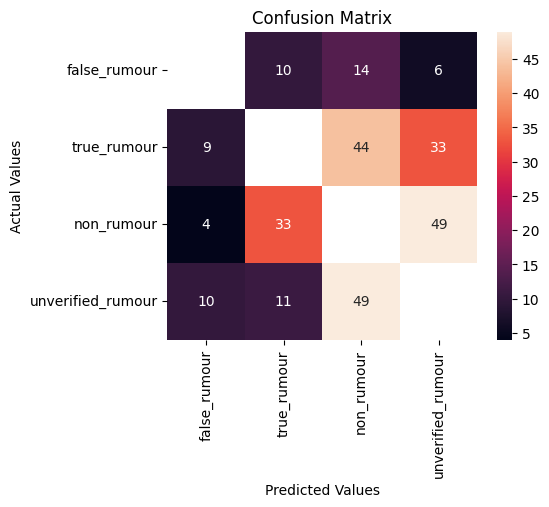

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score

f1 = f1_score(labellings, guesses,average = 'weighted') #not enough data for last batch so slice out from y_test
print(f1)
precision = precision_score(labellings, guesses,average = 'weighted')
recall = recall_score(labellings, guesses,average = 'weighted')
print(precision)
print(recall)
cm = confusion_matrix(labellings, guesses)

group_names = ['false_rumour','true_rumour','non_rumour','unverified_rumour']
cm_df = pd.DataFrame(cm,
                     index = group_names, 
                     columns = group_names)
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
off_diag_mask = np.eye(*cm_df.shape, dtype=bool)
sns.heatmap(cm_df, annot=True, mask=off_diag_mask,fmt='')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()